In [483]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import linalg
from scipy.optimize import linprog
from numpy.linalg import matrix_rank as rank
import torch

In [484]:
# Models
import sys
sys.path.append("..")
from models import MLP
from metrics import jacobian
from data_generation import RandomPolynomialMapping

In [549]:
def check_global(A,v,X,y,d0,d1,n):
    """
    Solves a linear program to check if there exists a global solution to the optimization program
    within a given region.
    
    Inputs:
    - A is an (d1 x n) binary array representing the preactivation positive activations
    - v is a (d1 x1) array holding the output weights of the network
    - X is an (d0, n) array holding the data features
    - y is an (n,1) array holding the data targets
    
    """
    B = -2*A+1
    Eq = np.zeros((n, d0*d1))
    Iq = np.zeros((n*d1, d0*d1))
    # Form equality and inequality matrices for linear program
    for i in range(n):
        x = X[:,i]
        for j in range(d1):
            start = j*d0
            end = (j+1)*d0
            Iq[(i*d1)+j,start:end]=B[j,i]*x
            Eq[i,start:end]=v[j]*A[j,i]*x
    results = linprog(np.zeros(d0*d1), A_ub=Iq, b_ub=np.zeros(n*d1), A_eq=Eq, b_eq=y)
#     print(results.message)
    return results.success, results.status

# options={"rr_method":"pivot", }

In [550]:
def generate_gauss_data(d0, n):
    X = np.random.randn(n,d0)
    y = np.random.randn(n, 1)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    return X, y

def generate_uniform_data(d0, n):
    X = 2*np.random.rand(n,d0)-1
    y = 2*np.random.rand(n, 1)-1
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    return X, y

def generate_teacher_student_data(d0, d1, d2, L, n, data_func):
    model = MLP(d0, d1, d2, L)
    X,_ = data_func(d0, n)
    y = model(X).detach()
    return X, y

In [551]:
# Rank functions for d = 1 case: here we uniformly sample non-empty activation regions
# by sampling mutually iid step rows uniformly at random
# Sample step row
def sample_step_vector(n):
    """
    Samples a step vector drawn uniformly at random.
    Inputs:
        - n is the row length / number of samples in the training set
    Outputs:
        - a step vector
    """
    pos = np.random.randint(n, size=1)[0]
    row = np.concatenate((np.zeros(pos, dtype = bool), np.ones(n-pos, dtype = bool))) 
    if np.random.randint(2, size=1)[0]:
        row = np.invert(row)
    return row

In [552]:
def sample_activation_region(d0, d1, n, data_func, d2=1, L=1, teacher=True):
    if teacher:
        X, y = generate_teacher_student_data(d0, d1, d2, L, n, data_func)
    else:    
        X, y = data_func(d0, n)
    if d0 == 1:
        A = np.zeros((d1, n))
        for r in range(d1):
            A[r,:] = sample_step_vector(n)
        J = linalg.khatri_rao(A, X.T)
        v =np.concatenate((-np.ones(int(d1/2)), np.ones(int(d1/2))))
    else:
        model = MLP(d0, d1, d2, L)
#         J = jacobian(model, X).detach().numpy()
        W = model.layers[0].weight.detach()
        P =(W@X.T).detach().numpy()
        A = P>0
        J = linalg.khatri_rao(A, X.T)
        v = model.last_layer.detach().numpy()
    X = X.detach().numpy().T
    r = rank(J)
    has_global_min, lp_status = check_global(A,v,X,y,d0,d1,n)
    return r, has_global_min, lp_status

# def sample_activation_region(d0, d1, n, data_func, d2=1, L=1):
#     model = MLP(d0, d1, d2, L)
#     X, y = data_func(d0, n)
#     J = jacobian(model, X).detach().numpy()
#     r = rank(J)
#     W = model.layers[0].weight.detach()
#     P =(W@X.T).detach().numpy()
#     A = P>0
#     W = W.numpy()
#     X = X.detach().numpy().T
#     v = model.last_layer.detach().numpy()
#     has_global_min = check_global(A,v,X,y,d0,d1,n)
#     return r, has_global_min

## Test

In [472]:
# Define number data points, size of hidden layer, data dimension and number of trials
d0=3
N = np.arange(2,12,1)
D1 = np.arange(10,20,1)
T = 10

poly = RandomPolynomialMapping(-1,1,2)
# X,y= poly.generate_random_data(d0, n)

In [494]:
av_rank_J = np.zeros((len(D1), len(N)))
av_globals = np.zeros((len(D1), len(N)))
for i in range(len(D1)):
    for j in range(len(N)):
        print("Computing average stats for d1="+str(D1[i]) + ", n=" + str(N[j]))
        for t in range(T):
            r, g, lp_status = sample_activation_region(d0, D1[i], N[j], generate_uniform_data, teacher = True)
            print("LP status outcome: "+ str(lp_status))
            av_rank_J[i,j] += r
            av_globals[i,j] += g
        av_rank_J[i,j] = 100*av_rank_J[i,j]/(T*N[j])
        av_globals[i,j] = av_globals[i,j]/T


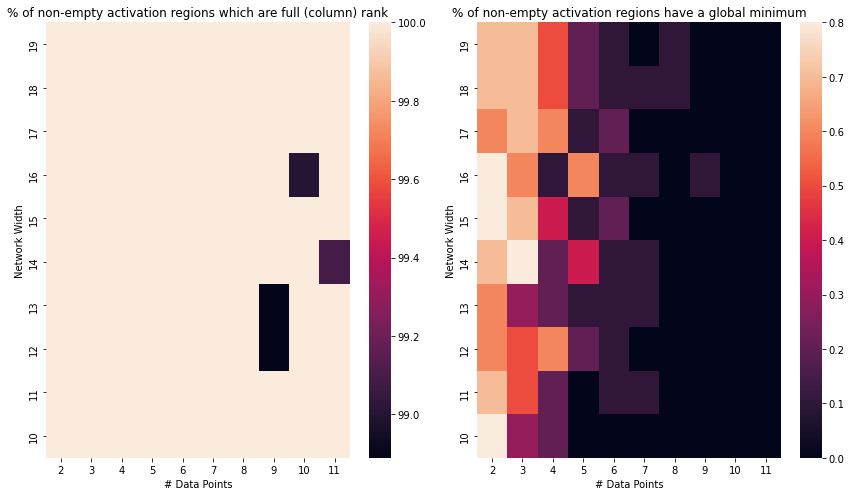

In [474]:
fig, ax = plt.subplots(1,2,figsize=(12, 7))
sns.heatmap(av_rank_J, ax=ax[0], xticklabels=N, yticklabels=D1)
sns.heatmap(av_globals, ax=ax[1], xticklabels=N, yticklabels=D1)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_xlabel("# Data Points")
ax[1].set_xlabel("# Data Points")
ax[0].set_ylabel("Network Width")
ax[1].set_ylabel("Network Width")
ax[0].set_title("% of non-empty activation regions which are full (column) rank")
ax[1].set_title("% of non-empty activation regions have a global minimum")
plt.tight_layout()

## Experiments for fixed d0

In [615]:
# D0 = [1,2,3,5] 
D0 = [1]
N = np.arange(100,151,10)
D1 = np.arange(500,551,10)
T = 1

In [616]:
av_rank_J = np.zeros((len(D0), len(D1), len(N)))
av_globals = np.zeros((len(D0), len(D1), len(N)))
for k in range(len(D0)):
    for i in range(len(D1)):
        for j in range(len(N)):
            print("Computing average statistics for d0= "+str(D0[k])+", d1="+str(D1[i]) + ", n=" + str(N[j]))
            for t in range(T):
                r, g, lp_status = sample_activation_region(D0[k], D1[i], N[j], generate_uniform_data, teacher = False)
                print("LP status outcome: "+ str(lp_status))
                av_rank_J[k,i,j] += r
                av_globals[k,i,j] += g
            av_rank_J[k,i,j] = 100*av_rank_J[k,i,j]/(T*N[j])
            av_globals[k,i,j] = av_globals[k,i,j]/T

Computing average statistics for d0= 1, d1=500, n=100
LP status outcome: 2
Computing average statistics for d0= 1, d1=500, n=110
LP status outcome: 2
Computing average statistics for d0= 1, d1=500, n=120
LP status outcome: 2
Computing average statistics for d0= 1, d1=500, n=130
LP status outcome: 2
Computing average statistics for d0= 1, d1=500, n=140
LP status outcome: 2
Computing average statistics for d0= 1, d1=500, n=150
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=100
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=110
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=120
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=130
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=140
LP status outcome: 2
Computing average statistics for d0= 1, d1=510, n=150
LP status outcome: 2
Computing average statistics for d0= 1, d1=520, n=100
LP status outcome: 2
Computing average statist

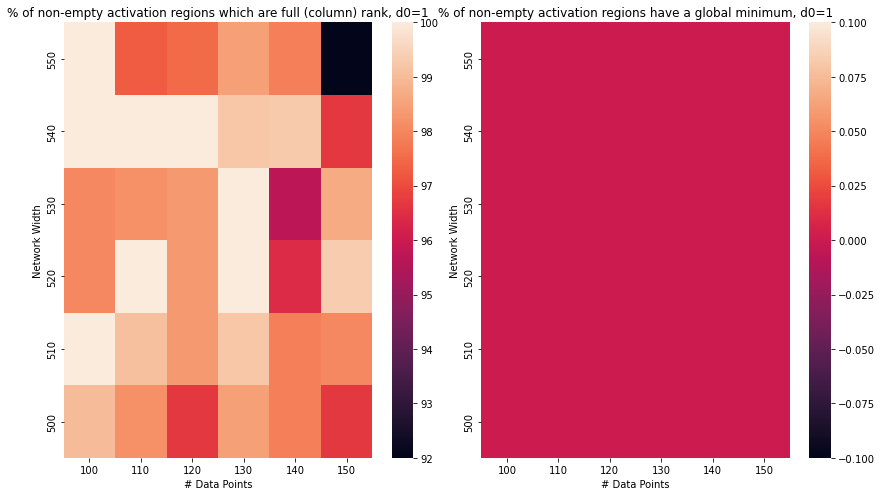

In [617]:
fig, ax = plt.subplots(1,2,figsize=(12, 7))
for j in range(2):
    if j == 0:
        sns.heatmap(av_rank_J[0], ax=ax[j], xticklabels=N, yticklabels=D1)
        ax[j].set_title("% of non-empty activation regions which are full (column) rank, d0=" + str(D0[0]))
    else:
        sns.heatmap(av_globals[0], ax=ax[j], xticklabels=N, yticklabels=D1)
        ax[j].set_title("% of non-empty activation regions have a global minimum, d0=" + str(D0[0]))
    ax[j].invert_yaxis()
    ax[j].set_xlabel("# Data Points")
    ax[j].set_ylabel("Network Width")
    plt.tight_layout()

In [600]:
fig, ax = plt.subplots(len(D0),2 ,figsize=(12, 7))
for k in range(len(D0)):
    for j in range(2):
        if j == 0:
            sns.heatmap(av_rank_J[k], ax=ax[k,j], xticklabels=N, yticklabels=D1)
            ax[k,j].set_title("% of non-empty activation regions which are full (column) rank, d0=" + str(D0[k]))
        else:
            sns.heatmap(av_globals[k], ax=ax[k,j], xticklabels=N, yticklabels=D1)
            ax[k,j].set_title("% of non-empty activation regions have a global minimum, d0=" + str(D0[k]))
    ax[k,j].invert_yaxis()
    ax[k,j].set_xlabel("# Data Points")
    ax[k,j].set_ylabel("Network Width")
plt.tight_layout()

In [614]:
### Place to do inspections

In [524]:
if teacher:
    X, y = generate_teacher_student_data(d0, d1, d2, L, n, generate_uniform_data)
else:    
    X, y = generate_uniform_data(d0, n)
if d0 == 1:
    for r in range(d1):
        A[r,:] = sample_step_vector(n)
    J = linalg.khatri_rao(A, X.T)
    v =np.concatenate((-np.ones(int(d1/2)), np.ones(int(d1/2))))
else:
    model = MLP(d0, d1, d2, L)
#         J = jacobian(model, X).detach().numpy()
    W = model.layers[0].weight.detach()
    P =(W@X.T).detach().numpy()
    A = P>0
    J = linalg.khatri_rao(A, X.T)
    v = model.last_layer.detach().numpy()
X = X.detach().numpy().T
r = rank(J)
# has_global_min = check_global(A,v,X,y,d0,d1,n)

In [525]:
B = -2*A+1
Eq = np.zeros((n, d0*d1))
Iq = np.zeros((n*d1, d0*d1))
# Form equality and inequality matrices for linear program
for i in range(n):
    x = X[:,i]
    for j in range(d1):
        start = j*d0
        end = (j+1)*d0
        Iq[(i*d1)+j,start:end]=B[j,i]*x
        Eq[i,start:end]=v[j]*A[j,i]*x

In [526]:
Eq

array([[ 0.03149468,  0.11624824,  0.        ,  0.        , -0.01523818,
        -0.05624477,  0.0321091 ,  0.11851606, -0.09262424, -0.34188005,
        -0.09523448, -0.35151455, -0.        , -0.        , -0.04036537,
        -0.14899032, -0.00537885, -0.01985358, -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.14835528,
        -0.09570759,  0.31260654,  0.20167007, -0.        , -0.        ,
        -0.92718023, -0.59814644, -0.        , -0.        , -0.39298767,
        -0.25352588, -0.        , -0.        , -0.        , -0.        ],
       [-0.13058718, -0.06572991, -0.04904878, -0.02468827,  0.        ,
         0.        , -0.        , -0.        ,  0.38405013,  0.19330826,
         0.        ,  0.        ,  0.2068451 ,  0.10411368,  0.        ,
         0.        ,  0.02230246,  0.01122575,  0.01207325,  0.00607696],
       [-0.21192211, -0.11726969, -0.07959833, -0.04404671,  0.        ,
         0.        , -0.        , -0.        ,  

In [527]:
rank(Eq)

5

In [528]:
Eq.shape

(5, 20)